In [1]:
import pandas as pd
import matplotlib.pyplot as plt

chemin_fichier_csv = 'DBfinal.csv'
dataset = pd.read_csv(chemin_fichier_csv)

In [2]:
print(dataset.head())

                                                 eng  \
0  The French presentation was a piece of cake fo...   
1  For the professional chef, creating a gourmet ...   
2  Learning to ride a bicycle was a piece of cake...   
3  Managing a team of experienced professionals w...   
4  The science experiment may seem difficult, but...   

                                                  fr  
0  La présentation en français était un jeu d'enf...  
1  Pour le chef professionnel, créer un gâteau go...  
2  Apprendre à faire du vélo était un jeu d'enfan...  
3  Gérer une équipe de professionnels expérimenté...  
4  L'expérience scientifique peut sembler diffici...  


In [5]:
# Check for missing values in the dataset
missing_eng_before = dataset['eng'].isna().sum()
missing_fr_before = dataset['fr'].isna().sum()

print(f"Number of missing values in the 'eng' column before removal: {missing_eng_before}")
print(f"Number of missing values in the 'fr' column before removal: {missing_fr_before}")

# Drop rows with missing values in 'eng' and 'fr' columns
dataset_cleaned = dataset.dropna(subset=['eng', 'fr'])

missing_eng_after = dataset_cleaned['eng'].isna().sum()
missing_fr_after = dataset_cleaned['fr'].isna().sum()

print(f"Number of missing values in the 'eng' column after removal: {missing_eng_after}")
print(f"Number of missing values in the 'fr' column after removal: {missing_fr_after}")

Number of missing values in the 'eng' column before removal: 0
Number of missing values in the 'fr' column before removal: 0
Number of missing values in the 'eng' column after removal: 0
Number of missing values in the 'fr' column after removal: 0


In [6]:
# Calculate the length of sentences
dataset_cleaned.loc[:, 'english_length'] = dataset_cleaned['eng'].str.split().apply(len)
dataset_cleaned.loc[:, 'french_length'] = dataset_cleaned['fr'].str.split().apply(len)

# Display descriptive statistics
print("Statistics for English:")
print(dataset_cleaned['english_length'].describe())
print("\nStatistics for French:")
print(dataset_cleaned['french_length'].describe())


Statistics for English:
count    118387.000000
mean         11.916435
std           4.360699
min           1.000000
25%           9.000000
50%          12.000000
75%          15.000000
max          35.000000
Name: english_length, dtype: float64

Statistics for French:
count    118387.000000
mean         12.660976
std           5.067051
min           1.000000
25%          10.000000
50%          13.000000
75%          16.000000
max          42.000000
Name: french_length, dtype: float64


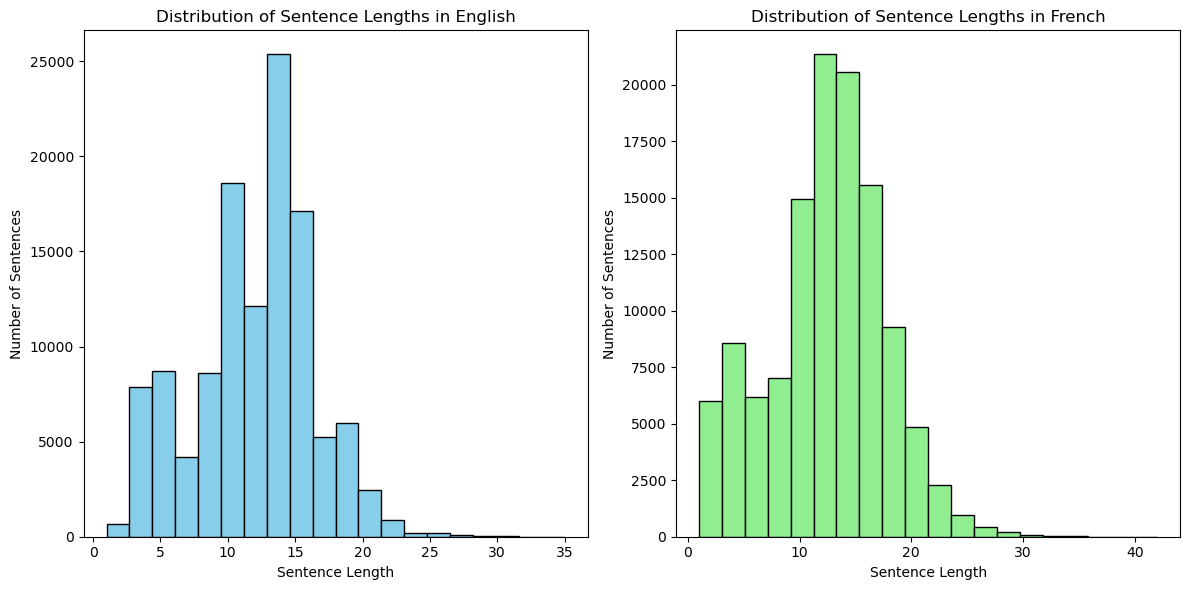

In [7]:
# Plot the distribution of sentence lengths
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(dataset_cleaned['english_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentence Lengths in English')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')

plt.subplot(1, 2, 2)
plt.hist(dataset_cleaned['french_length'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Sentence Lengths in French')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')

plt.tight_layout()
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

# Perform the train-test split
train, test = train_test_split(dataset_cleaned, test_size=0.01)

print(f"Training set size: {len(train)}")
print(f"Test set size: {len(test)}")


Training set size: 117203
Test set size: 1184


In [10]:
from transformers import MarianTokenizer

model_name = "Helsinki-NLP/opus-mt-fr-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)


In [12]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)

In [13]:
def preprocess_function(examples):
    # Tokenizing French sentences
    inputs = tokenizer(examples["fr"], max_length=35, truncation=True, padding="max_length")
    # Tokenizing English translations (targets)
    targets = tokenizer(examples["eng"], max_length=35, truncation=True, padding="max_length")
    return {"input_ids": inputs.input_ids, "attention_mask": inputs.attention_mask, "labels": targets.input_ids}

# Apply the preprocessing function to the training and test datasets
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/117203 [00:00<?, ? examples/s]

Map:   0%|          | 0/1184 [00:00<?, ? examples/s]

In [14]:
examples = train.sample(5)
print("Examples of sentences:")
for i, row in examples.iterrows():
    print(f"FR: {row['fr']} -> ENG: {row['eng']}")

print("Tokens of the sentences:")
for i, row in examples.iterrows():
    tokens_fr = tokenizer(row['fr'], max_length=128, truncation=True, padding="max_length")
    tokens_eng = tokenizer(row['eng'], max_length=128, truncation=True, padding="max_length")
    tokens_fr_ids = tokens_fr.input_ids
    tokens_eng_ids = tokens_eng.input_ids
    tokens_fr_words = tokenizer.convert_ids_to_tokens(tokens_fr_ids)
    tokens_eng_words = tokenizer.convert_ids_to_tokens(tokens_eng_ids)
    print(f"FR: {row['fr']} -> Tokens FR: {tokens_fr_words}")
    print(f"ENG: {row['eng']} -> Tokens ENG: {tokens_eng_words}")




Examples of sentences:
FR: La vieille photo s'envola, comme de la poussière dans le vent, emportée par une rafale soudaine. -> ENG: The old photograph fluttered away, like dust in the wind, carried off by a sudden gust
FR: l'équipe a corrigé le bogue logiciel urgent immédiatement, puis a peaufiné l'interface pendant le weekend -> ENG: the team fixed the urgent software bug immediately, then refined the interface over the weekend
FR: Il affirme toujours que le jardinage est un jeu d'enfant, mais c'est en réalité assez laborieux. -> ENG: 5. He always says gardening is a piece of cake, but it's actually quite laborintensive
FR: Les preuves présentées au tribunal ont prouvé sa culpabilité hors de tout doute. -> ENG: The evidence presented in court proved his guilt beyond the shadow of a doubt.
FR: un jeu d'enfant -> ENG: a piece of cake
Tokens of the sentences:
FR: La vieille photo s'envola, comme de la poussière dans le vent, emportée par une rafale soudaine. -> Tokens FR: ['▁La', '▁vieil

In [14]:
rom transformers import MarianMTModel, MarianConfig, TrainingArguments, Trainer
import torch

# Configuration and model setup
model_name = "Helsinki-NLP/opus-mt-fr-en"
config = MarianConfig.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name, config=config)

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  
print(f"The model is using: {device}")

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",  # Directory to save results
    num_train_epochs=10,  
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,  
    warmup_steps=500,  #it is for learning rate scheduler
    weight_decay=0.01,  
    logging_dir="./logs",  
    eval_strategy="epoch",  
    save_strategy="epoch",  
    save_total_limit=3,  
    no_cuda=not torch.cuda.is_available(),  
    dataloader_num_workers=4,  
    dataloader_prefetch_factor=2  
)

# Trainer setup
trainer = Trainer(
    model=model, 
    args=training_args,  
    train_dataset=tokenized_train_dataset, 
    eval_dataset=tokenized_test_dataset 
)

# Start training
trainer.train()

C:\Users\duody\anaconda3\envs\envforcuda\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Le modèle utilise : cuda


Epoch,Training Loss,Validation Loss
1,0.347900,0.294690
2,0.245200,0.237958
3,0.192600,0.218659
4,0.152800,0.209546
5,0.128500,0.205748
6,0.109000,0.204734
7,0.088300,0.204116
8,0.077000,0.205460
9,0.064600,0.208875
10,0.057100,0.209996


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strate

TrainOutput(global_step=73260, training_loss=0.171840125955326, metrics={'train_runtime': 32282.6773, 'train_samples_per_second': 36.305, 'train_steps_per_second': 2.269, 'total_flos': 1.08636447080448e+16, 'train_loss': 0.171840125955326, 'epoch': 10.0})

In [15]:
tokenizer.save_pretrained('./chemin_de_sauvegarde1')

('./chemin_de_sauvegarde1\\tokenizer_config.json',
 './chemin_de_sauvegarde1\\special_tokens_map.json',
 './chemin_de_sauvegarde1\\vocab.json',
 './chemin_de_sauvegarde1\\source.spm',
 './chemin_de_sauvegarde1\\target.spm',
 './chemin_de_sauvegarde1\\added_tokens.json')

In [8]:
from transformers import MarianMTModel, MarianTokenizer

model_path = "./resultsFR/checkpoint-73260" 
model = MarianMTModel.from_pretrained(model_path)
tokenizer = MarianTokenizer.from_pretrained(model_path)


def translate(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(model.device)
    translated_tokens = model.generate(**inputs)
    translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
    return translated_text

source_text = "l'ambiance était de marbre"
translated_text = translate(source_text, model, tokenizer)
print(translated_text)

the atmosphere was stonecold


In [19]:
from transformers import MarianMTModel, MarianTokenizer

# Load models and tokenizers
model_path = "./resultsFR/checkpoint-73260"  # Replace with the correct path
custom_model = MarianMTModel.from_pretrained(model_path)
custom_tokenizer = MarianTokenizer.from_pretrained(model_path)

pretrained_model_name = "Helsinki-NLP/opus-mt-fr-en"
pretrained_tokenizer = MarianTokenizer.from_pretrained(pretrained_model_name)
pretrained_model = MarianMTModel.from_pretrained(pretrained_model_name)

# Translation function
def translate(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=35).to(model.device)
    translated_tokens = model.generate(**inputs)
    translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
    return translated_text

# Idiomatic phrases
idiomatic_phrases = [
    "Ils en ont fait tout un fromage pour un petit problème.",  
    "En faire tout un fromage",  
    "Avec ce projet compliqué, ils vont devenir chèvres.",  
    "Pour lui, résoudre cette équation était un jeu d'enfant.",  
    "Après l'annonce de sa promotion, elle était aux anges.",  
    "Avec leur nouvelle stratégie, ils ont le vent en poupe.",  
    "Il a travaillé d'arrache-pied pour terminer le projet avant la date limite, ne prenant pas une seule pause.",
    "Même après l'accident, elle a repris le volant, déterminée à ne pas se laisser abattre.",
    "Quand il a appris la nouvelle, il a fondu en larmes, incapable de contrôler ses émotions.",
    "Elle a mis les points sur les i lors de la réunion, clarifiant tous les malentendus.",
    "Il a dû se serrer la ceinture pendant des mois pour économiser assez d'argent pour son voyage.",
    "Même en plein désastre, il a gardé son sang-froid et a trouvé une solution.",
    "Ils ont vendu la mèche sans s'en rendre compte, révélant accidentellement leur plan.",
    "Elle a pris la mouche quand il a critiqué son travail, se sentant profondément offensée.",
    "Il a fallu qu'elle se mouille pour convaincre ses collègues d'accepter le nouveau projet.",
    "Après des heures de discussions, ils ont enfin trouvé un terrain d'entente et signé le contrat.",
    "Il a mis de l'huile sur le feu avec ses remarques acerbes, aggravant encore plus la situation.",
    "Elle a sauté sur l'occasion dès qu'elle a entendu parler de l'ouverture du poste.",
    "Ils ont décidé de tirer un trait sur le passé et de recommencer à zéro.",
]

# Compare translations
comparisons = []
for phrase in idiomatic_phrases:
    custom_translation = translate(phrase, custom_model, custom_tokenizer)
    pretrained_translation = translate(phrase, pretrained_model, pretrained_tokenizer)
    comparisons.append((phrase, custom_translation, pretrained_translation))

# Display results
for phrase, custom_translation, pretrained_translation in comparisons:
    print(f"Phrase: {phrase}")
    print(f"Custom Model Translation: {custom_translation}")
    print(f"Pretrained Model Translation: {pretrained_translation}")
    print("="*50)


Phrase: Ils en ont fait tout un fromage pour un petit problème.
Custom Model Translation: They made a big fuss over a small issue
Pretrained Model Translation: They made a whole cheese for a little problem.
Phrase: En faire tout un fromage
Custom Model Translation: to make a mountain out of a molehill
Pretrained Model Translation: Make a whole cheese
Phrase: Avec ce projet compliqué, ils vont devenir chèvres.
Custom Model Translation: With that complicated project, they're going to go go good
Pretrained Model Translation: With this complicated project, they're going to become goats.
Phrase: Pour lui, résoudre cette équation était un jeu d'enfant.
Custom Model Translation: For him, solving that equation was a piece of cake.
Pretrained Model Translation: To him, solving this equation was a child's play.
Phrase: Après l'annonce de sa promotion, elle était aux anges.
Custom Model Translation: After hearing the announcement of her promotion, she was on cloud nine.
Pretrained Model Translati